# Mijnarends et al. (2022): Finding accreted stars in the Milky Way: clues from NIHAO simulations

In [8]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob
import scipy
# import corner
import os
import pandas
from astropy.table import Table, hstack, vstack, join
from astropy.io import fits
from scipy.spatial import ConvexHull

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

# Part 1: Prepare Data

## 1a) Read in the data from GALAH+ DR3.  
We already have cross-matched the main catalog and the value-added catalogs via sobject_id.  
The catalog data is provided at https://datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/   
The analysis is described by Buder et al. (2022): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B.  

In [59]:
fits_file = fits.open('GALAH_DR3_all_joined_v2.fits')
obs = fits_file[1].data
fits_file.close()

# For the observations, we need to apply some quality checks to only continue with high-fidelity data
# By default, we choose the following:
observation_quality_check_default = (
    (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
    (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

## 1b) Read in the simulation
The simulation is part of the NIHAO suite.  
This particular simulation can be retrieved from Tobias Buck.  
It is described in detail in Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B

In [57]:
fits_file = fits.open('simulation_data_220118.fits')
sim = fits_file[1].data
fits_file.close()

# Part 2: Overview of the abundances in observation and simulations

The simulation traces the chemical evolution of the following elements:  
H, He, C, N, O, Ne, Mg, Al, Si, P, S, V, Cr, Mn, Fe, Co, Ba.  

Of these, the following ten are also reported by the GALAH survey:  
C, O, Mg, Al, Si, V, Cr, Mn, Co and Ba

Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.


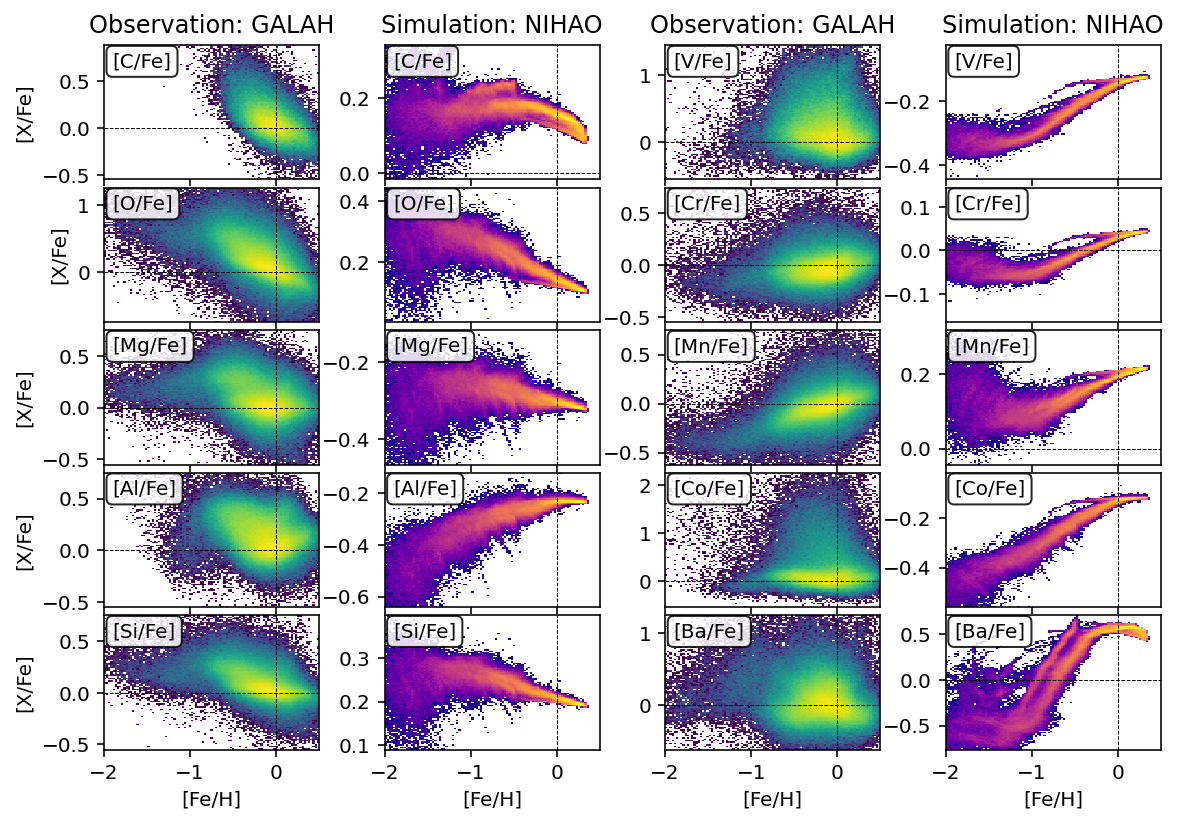

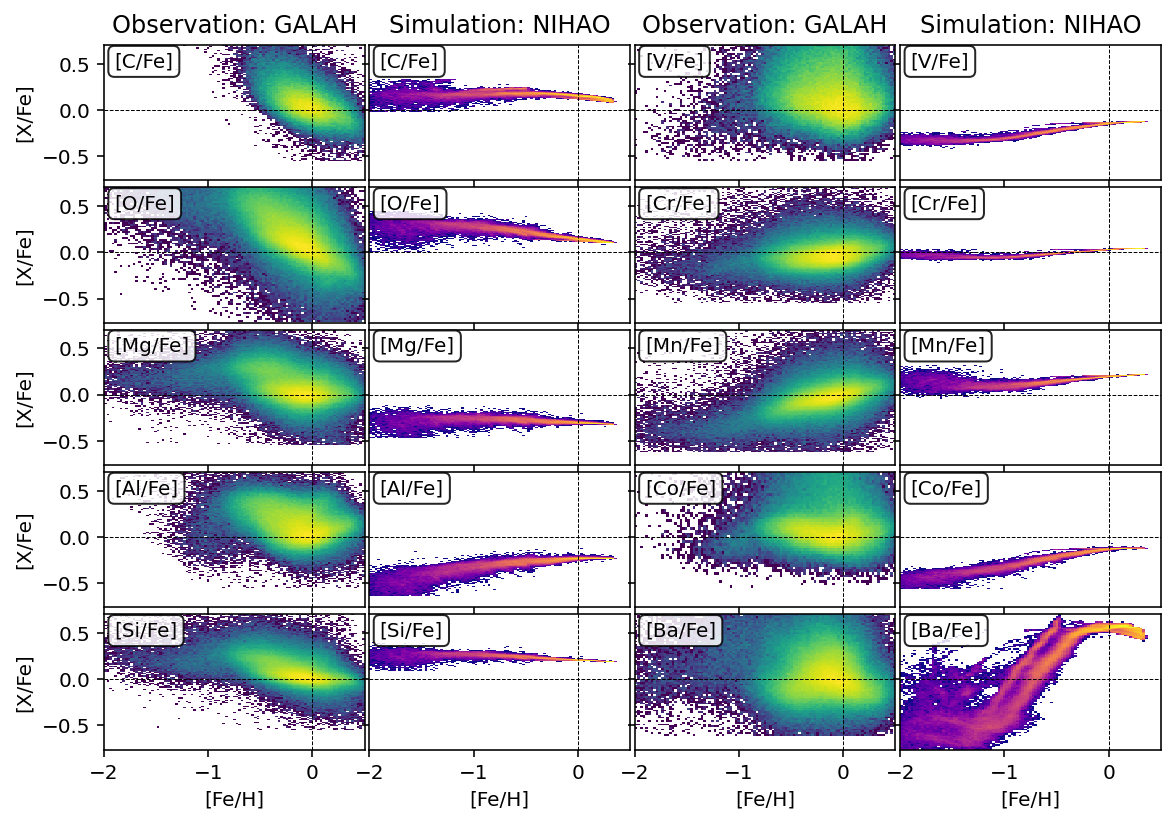

In [11]:
# Let's plot an overview of all these 10 elements:

def plot_abundance_overview_observations_simulations(sharey=False):
    """
    Distribution of elemental abundances [X/Fe] versus [Fe/H] 
    for the ten elements overlapping between GALAH and NIHAO.
    
    Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities.
    For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. 
    Dashed lines indicate Solar values.
    
    INPUT:
    sharey = False/True: Shall the abundances [X/Fe] be plotted on the same y-axis range?
    
    OUTPUT:
    plt.savefig() with or without shary
    
    """

    f, gs = plt.subplots(5,4,sharex=True,sharey=sharey,figsize=(8.27, 11.69/2.))

    for element_index, element in enumerate(['C','O','Mg','Al','Si','V','Cr','Mn','Co','Ba']):

        # For better visibility, we limit ourselves to [Fe/H] > -2 in both observations and simulations
        fe_h_lower_limit = -2
        
        # Observations are shown in first and third row with simulated distributions in the row next to them. 
        if element_index <= 4:
            ax_obs = gs[element_index,0]
            ax_sim = gs[element_index,1]
        else:
            ax_obs = gs[element_index-5,2]
            ax_sim = gs[element_index-5,3]

        ######
        # Panels with observations
        ######
        
        # We apply our usual quality checks, but here for each element individually
        observation_quality_check = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) &
            (obs['flag_'+element+'_fe'] == 0) &
            (obs['fe_h'] >= fe_h_lower_limit)
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex (but at least -0.55 and 0.75)
        xfe_obs = obs[element+'_fe'][observation_quality_check]
        percentiles_obs = np.percentile(xfe_obs,q=[0.5,99.5])
        ax_obs.hist2d(
            obs['fe_h'][observation_quality_check],
            obs[element+'_fe'][observation_quality_check],
            bins=(np.linspace(fe_h_lower_limit,0.5,100),np.linspace(np.min([-0.55,percentiles_obs[0]-0.1]),np.max([0.75,percentiles_obs[-1]+0.1]),100)),
            cmin = 1,
            norm = LogNorm()
        )
        
        ######
        # Panels with simulations
        ######
        
        simulation_hack = (
            (sim['Fe_H'] > fe_h_lower_limit) # This is just to make sure that the plot ranges do not explode...
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex
        sim_xfe = sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack]
        percentiles_sim = np.percentile(sim_xfe,q=[0.5,99.5])
        
        ax_sim.hist2d(
            sim['Fe_H'][simulation_hack],
            sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack],
            bins=(np.linspace(fe_h_lower_limit,0.5,100),np.linspace(percentiles_sim[0]-0.1,percentiles_sim[-1]+0.1,100)),
            cmin = 1,
            norm = LogNorm(),
            cmap = 'plasma'
        )

        # Add text with [X/Fe]
        ax_obs.text(0.04,0.95,'['+element+'/Fe]',transform=ax_obs.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax_sim.text(0.04,0.95,'['+element+'/Fe]',transform=ax_sim.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        # Add Solar value lines at (0,0)
        ax_obs.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_obs.axvline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axvline(0,lw=0.5,ls='dashed',c='k')
        
        # Add titles and x-/y-labels
        if element_index in [0,5]:
            ax_obs.set_title('Observation: GALAH')
            ax_sim.set_title('Simulation: NIHAO')
        if element_index in [4,9]:
            ax_obs.set_xlabel('[Fe/H]')
            ax_sim.set_xlabel('[Fe/H]')
        if element_index <= 4:        
            ax_obs.set_ylabel('[X/Fe]')
   
    plt.tight_layout(h_pad=0,w_pad=-0.5)
    if sharey:
        plt.savefig('figures/Overview_FeH_XFe_Obs_Sim_sharey.png',bbox_inches='tight',dpi=200)
    else:
        plt.savefig('figures/Overview_FeH_XFe_Obs_Sim.png',bbox_inches='tight',dpi=200)

plot_abundance_overview_observations_simulations(sharey=False)
plot_abundance_overview_observations_simulations(sharey=True)

print('Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.')

# Part 3: A closer look at the 'low-alpha halo'

This is inspired by the Nissen et al. (2010) plot finding different populations in the metal-poor low-/high-alpha halo regime

<ipython-input-7-1b31658cbb87>:21: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  p = ax.hist2d(
<ipython-input-7-1b31658cbb87>:55: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  p = ax.hist2d(


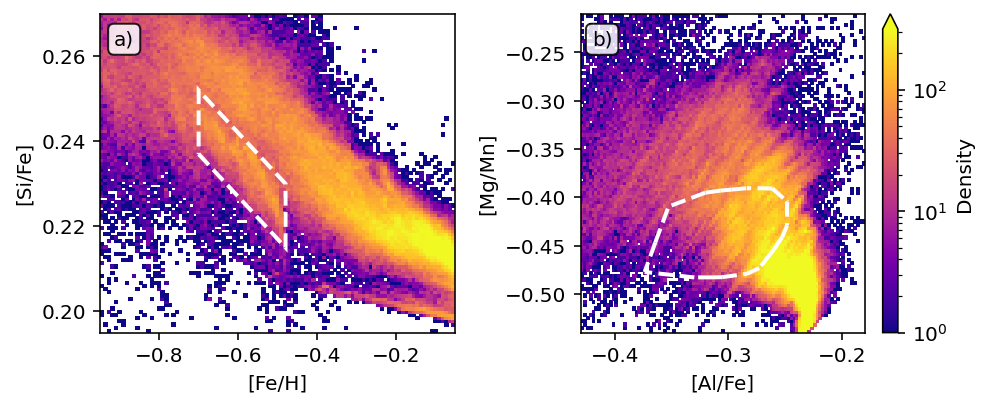

In [7]:
def plot_low_alpha_halo():

    f, gs = plt.subplots(1,2,figsize=(7,3))
    
    lower_feh_limit = -0.7
    upper_feh_limit = -0.48
    slope = -0.1
    intercept1 = 0.167
    intercept2 = 0.182
    
    select_low_alpha_halo = (
        (sim['Fe_H'] > lower_feh_limit) &
        (sim['Fe_H'] < upper_feh_limit) &
        (sim['Si_H'] - sim['Fe_H'] > intercept1 + slope*sim['Fe_H']) &
        (sim['Si_H'] - sim['Fe_H'] < intercept2 + slope*sim['Fe_H'])
    )
    
    ax = gs[0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p = ax.hist2d(
        sim['Fe_H'],
        sim['Si_H'] - sim['Fe_H'],
        bins = (np.linspace(-0.95,-0.05,100),np.linspace(0.195,0.27,100)),
        cmin = 1, cmap='plasma',
        vmin = 1, vmax = 10**2.5,
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
#     c.set_label('Density')
        
    polygon = Polygon(
        [
            [lower_feh_limit,intercept1 + slope*lower_feh_limit],
            [upper_feh_limit,intercept1 + slope*upper_feh_limit],
            [upper_feh_limit,intercept2 + slope*upper_feh_limit],
            [lower_feh_limit,intercept2 + slope*lower_feh_limit]
        ], 
        True,
        fill=False,
        edgecolor = 'w',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    
    
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Si/Fe]')
    
    # [Al/Fe] vs. [Mg/Mn]
    ax = gs[1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p = ax.hist2d(
        sim['Al_H'] - sim['Fe_H'],
        sim['Mg_H'] - sim['Mn_H'],
        bins = (np.linspace(-0.43,-0.18,100),np.linspace(-0.54,-0.21,100)),
        cmin = 1, cmap='plasma',
        vmin = 1, vmax = 10**2.5,
        norm = LogNorm()
    )
    c = plt.colorbar(p[-1],ax=ax,extend='max')
    c.set_label('Density')
    
    sim_al_fe = sim['Al_H'][select_low_alpha_halo] - sim['Fe_H'][select_low_alpha_halo]
    sim_mg_mn = sim['Mg_H'][select_low_alpha_halo] - sim['Mn_H'][select_low_alpha_halo]
    hull = ConvexHull(
        np.array([
            sim_al_fe,
            sim_mg_mn
        ]).T
    )
    for simplex in hull.simplices:
        ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'w', ls='dashed',lw=2)
    
    ax.set_xlabel('[Al/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    plt.tight_layout()
    
    plt.savefig('figures/low_alpha_halo.png',dpi=200,bbox_inches='tight')
    
plot_low_alpha_halo()

## [Mg/Mn] over [Alpha/Fe] (sim vs obs)

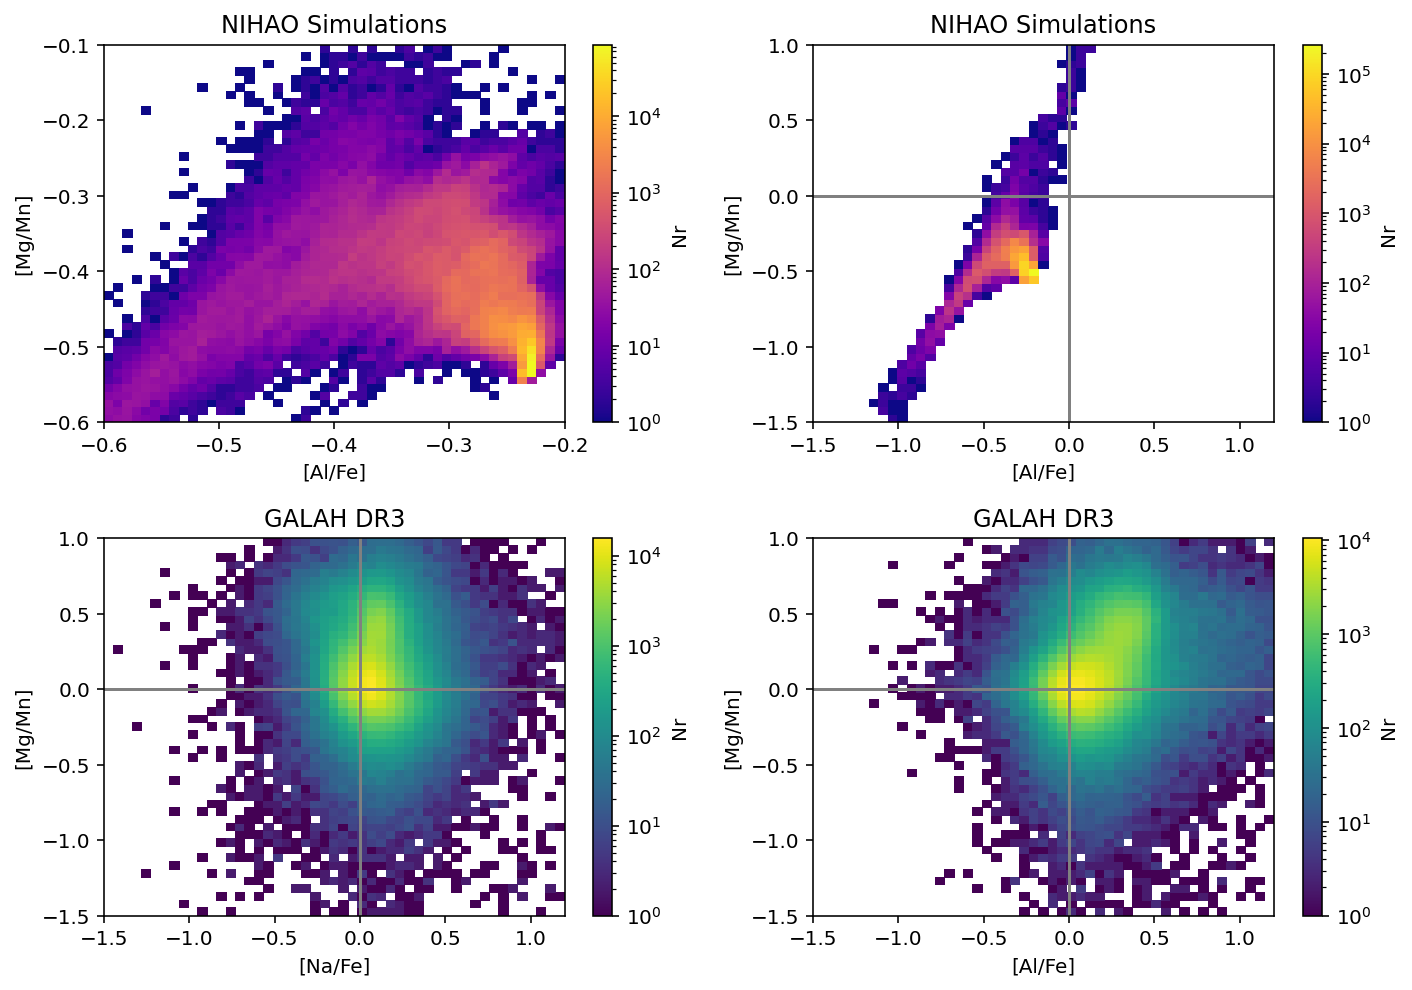

In [8]:
f, gs = plt.subplots(2,2,figsize=(10,7))#,sharex=True,sharey=True)

# Simulation: axes adjusted to show detail of plot
ax = gs[0,0]
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-0.6, -0.2, 50), np.linspace(-0.6, -0.1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Al/Fe]')
ax.set_ylabel('[Mg/Mn]')
s.set_cmap('plasma')
ax.set_title('NIHAO Simulations')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')

# Simulation: axes equal to observation plots for comparison
ax = gs[0,1]
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-1.5, 1.2, 50), np.linspace(-1.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Al/Fe]')
ax.set_ylabel('[Mg/Mn]')
ax.set_title('NIHAO Simulations')
s.set_cmap('plasma')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')

# Observation: against Na instead of Al, due to better observations 
ax = gs[1,0]
p, x, y, s = ax.hist2d(
    obs['Na_fe'],
    obs['Mg_fe']-obs['Mn_fe'],
    bins = (np.linspace(-1.5, 1.2, 50), np.linspace(-1.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Na/Fe]')
ax.set_ylabel('[Mg/Mn]')
ax.set_title('GALAH DR3')
s.set_cmap('viridis')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')

# Observation: against Al to compare to simulations
ax = gs[1,1]
p, x, y, s = ax.hist2d(
    obs['Al_fe'],
    obs['Mg_fe']-obs['Mn_fe'],
    bins = (np.linspace(-1.5, 1.2, 50), np.linspace(-1.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s,  ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Al/Fe]')
ax.set_ylabel('[Mg/Mn]')
ax.set_title('GALAH DR3')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')
s.set_cmap('viridis')
plt.tight_layout()

plt.savefig('[Mg_Mn]_[Al_Fe].png', dpi=200,bbox_inches='tight')


# Part 4: Elemental abundance over time

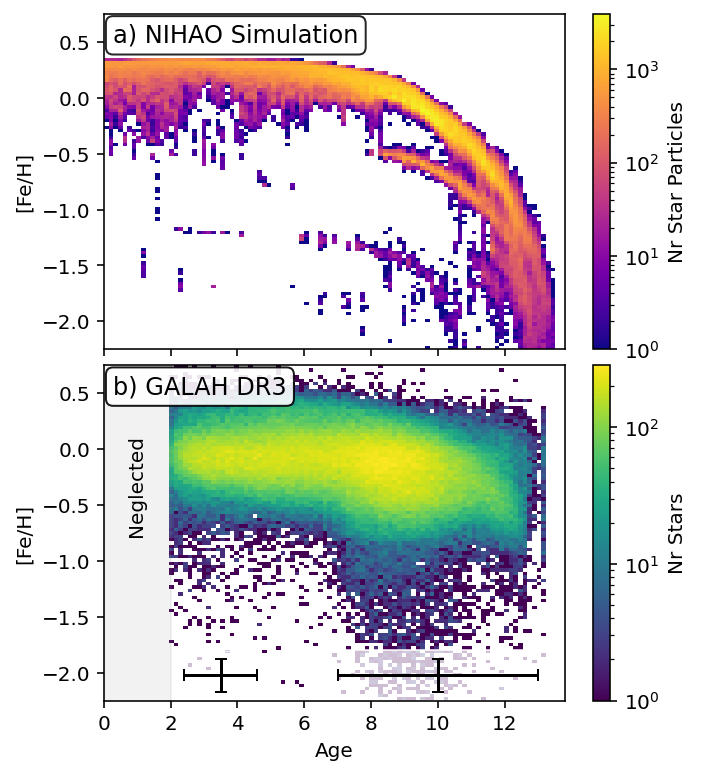

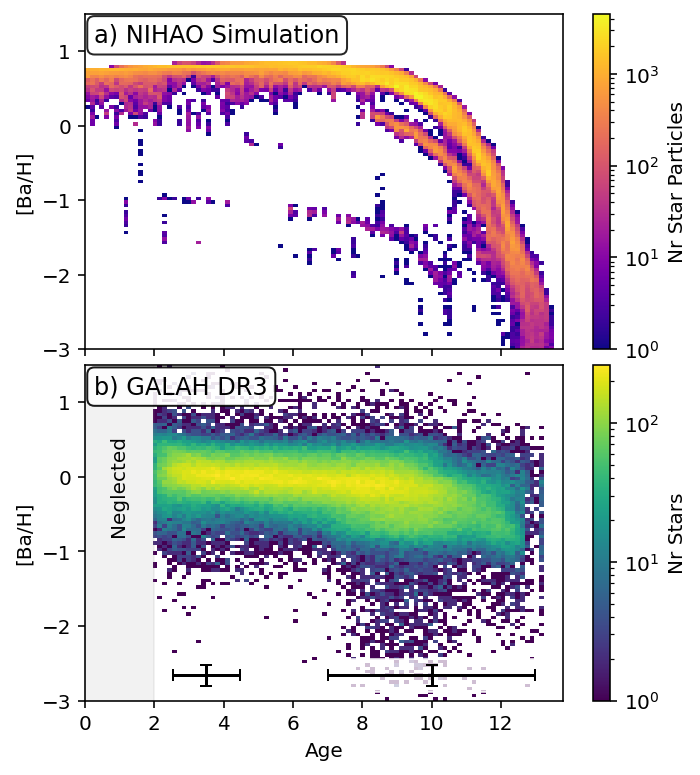

In [221]:
def plot_x_h_over_time(element = 'Fe'):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Fe':
        y_bins = np.linspace(-2.25, 0.75, 100)
    else:
        y_bins = np.linspace(-3, 1.5, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        sim[element+'_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    if element == 'Fe':
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['e_fe_h'] < 0.1) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = obs['fe_h']
        e_ydata = obs['e_fe_h']
    else:
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['flag_'+element+'_fe'] == 0) & 
            (obs['e_'+element+'_fe'] < 0.1) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = obs[element+'_fe'] + obs['fe_h']
        e_ydata = obs['e_'+element+'_fe']
        
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    error_position = [
        3.5,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] <7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout(h_pad=0)

    plt.savefig('figures/'+element+'_H_time.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
    
plot_x_h_over_time()
plot_x_h_over_time(element='Ba')

## Ba/Fe over Age 

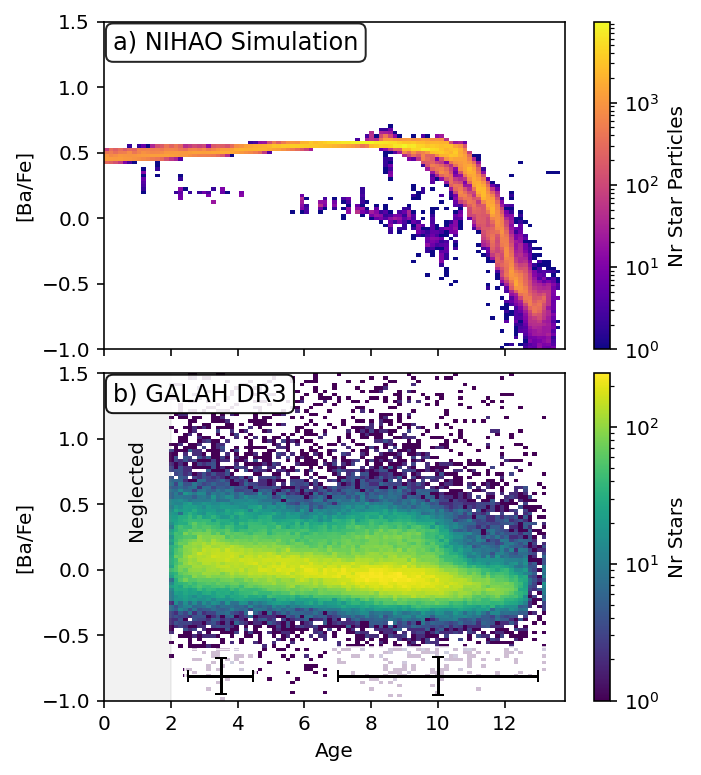

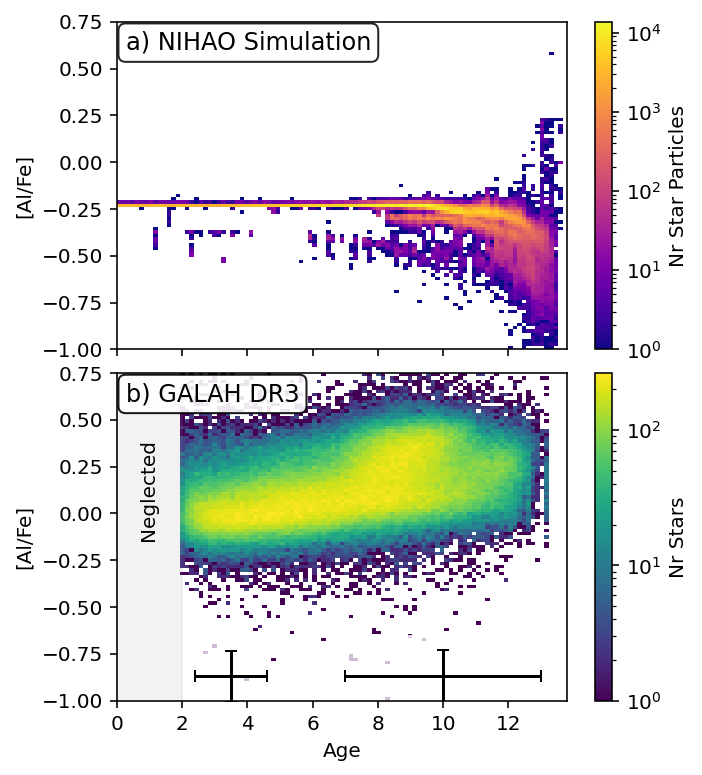

In [225]:
def plot_x_fe_over_time(element = 'Fe'):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Ba':
        y_bins = np.linspace(-1, 1.5, 100)
    elif element == 'Al':
        y_bins = np.linspace(-1, 0.75, 100)
    else:
        y_bins = np.linspace(-1, 1.5, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        sim[element+'_H']-sim['Fe_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/Fe]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    quality_cut = (
        (obs['flag_sp'] == 0) &
        (obs['flag_fe_h'] == 0) & 
        (obs['flag_'+element+'_fe'] == 0) & 
        (obs['e_'+element+'_fe'] < 0.1) & 
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
    )
    ydata = obs[element+'_fe']
    e_ydata = obs['e_'+element+'_fe']
        
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    error_position = [
        3.5,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] <7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel('['+element+'/Fe]')
    plt.tight_layout(h_pad=0)

    plt.savefig('figures/'+element+'_Fe_time.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
    
plot_x_fe_over_time(element='Ba')
plot_x_fe_over_time(element='Al')

# Part 5: Data analysis: Separation significance and uncertainties 

## Table 1: Separation Significance for in-situ and accreted sequences

In [11]:
# Defining the skeleton of the table 
table_text = [
    [r'\begin{table}'],
    [r'    \centering'],
    [r'    \caption{Separation significance for the simulated data between in-situ and accreted (accr.) sequences for abundances ratios [X/H] of ten elements X.}'],
    [r'    \begin{tabular}{cccccc}'],
    [r'    \hline'],
    [r'    Element & $\mu_\text{in-situ}$ & $\sigma_\text{in-situ}$ & $\mu_\text{accr.}$ & $\sigma_\text{accr.}$ & $r$\\'],
    [r'    \hline \hline']
]

# Outlining the lower and upper bounds of the two sequences (C as test)
low = ((sim['C_H'] < -0.2) & (sim['C_H'] > -0.6))& (sim['tform'] > 4) &  (sim['tform'] < 5) 
high = ((sim['C_H'] < 0.4) & (sim['C_H'] > -0.1))& (sim['tform'] > 4) &  (sim['tform'] < 5) 


def add_separation_significance(element):
        
    
    # Code that computes mu, sigma, r
    p16, p50, p84 = np.percentile(sim[''+element+'_H'][low], q=[16,50,84])
    mu_1 = p50
    sigma_1 = (p84-p16)/2
    
    p16, p50, p84 = np.percentile(sim[''+element+'_H'][high], q=[16,50,84])
    mu_2 = p50
    sigma_2 = (p84-p16)/2
    
    r = abs(mu_1 - mu_2) / np.sqrt(sigma_1**2 + sigma_2**2) 
    
    return(r'    {['+element+'/H]}  & '+str(round(mu_1,2))+' & '+str(round(sigma_1, 2))+' & '+str(round(mu_2, 2))+' & '+str(round(sigma_2, 2))+' & '+str(round(r, 2))+r' \\')
    
# Creating a loop for the table to run through each element 
for element in ['Mg', 'C', 'Mn', 'Si', 'Ba', 'V', 'Co', 'Al', 'Cr','O']:
    table_text.append([add_separation_significance(element)])

table_text.append([r'    \hline'])
table_text.append([r'    \end{tabular}'])
table_text.append([r'    \label{tab:r_values_simulation}'])
table_text.append([r'\end{table}'])

np.savetxt('tables/separation_significance_two_sequences.tex',table_text,fmt='%s')

# Table 2
## Measurement uncertainties required for significance

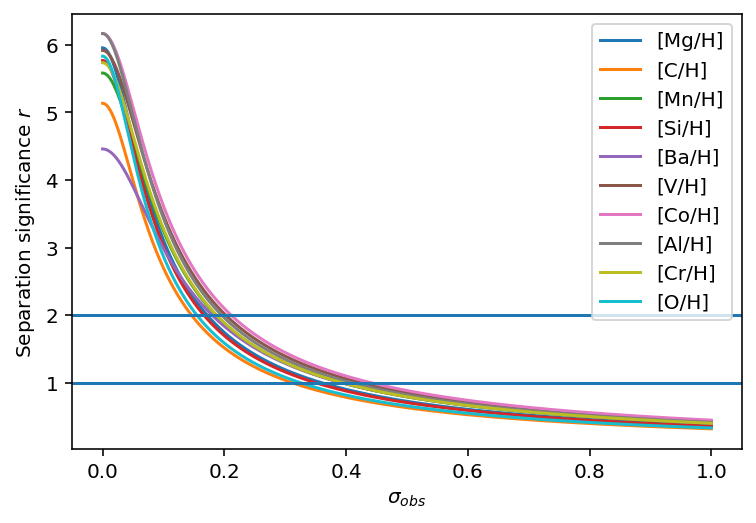

In [16]:
table_text_2 = [
    [r'\begin{table}'],
    [r'    \centering'],
    [r'    \caption{Observational uncertainties for each element that allow to separate the in-situ and accreted sequences at $8-9\,\mathrm{Gyr}$ with 95\% ($r>2$) and 68\% ($r>1$) certainty. The last rows report the percentage of measurements and their the median uncertainties for the element reported by GALAH DR3 (as indicators of how often and how well the element can be measured.}'],
    [r'    \begin{tabular}{ccccc}'],
    [r'    \hline'],
    [r'    Element & $\sigma_\text{obs}$ 95\% & $\sigma_\text{obs}$ 68\% & Det. Rate & $\sigma_\text{GALAH}$ \\'],
    [r'    \hline \hline']
]

def get_initial_mean_and_sigma(element):
    age_limits = (sim['tform'] > 4) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=100)

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    # These are 2 Gaussians combined
    def gauss2(x,a,x0,sigma,a1,x01,sigma1):
        return a*np.exp(-(x-x0)**2/(2*sigma**2)) + a1*np.exp(-(x-x01)**2/(2*sigma1**2))

    from scipy.optimize import curve_fit

    # This is simply "fitting" the 2 Gaussians to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[1,0,0.25,1,-0.4,0.5]
    )

    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]

#     plt.axvline(mean1)
#     plt.axvline(mean2)
   
#     plt.scatter(
#         bins,number
#     )
#     plt.plot(
#         bins,
#         gauss2(bins,*popt),
#         c='r'
#     )
    

### NEED TO RENAME VARIABLES TO BE CLEARER
### HOW WAS SIGMA_OBS DEFINED?
    sigma_obs = np.linspace(0,1,2000)
    sigma_1obs = np.sqrt(sigma1**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(sigma2**2 + sigma_obs**2)
    r_obs = abs(mean1 - mean2) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2) 
    plt.plot(sigma_obs, r_obs, label = '['+element+'/H]')
    plt.legend()
    plt.xlabel('$\sigma_{obs}$')
    plt.ylabel('Separation significance $r$')
    
    # NOT USED- trying to interpolate
    sigma_obs_list = np.array(sigma_obs)
    r_obs_list = np.array(r_obs)
    
    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]
    
    plt.axhline(1)
    plt.axhline(2)
    
    # Obtaining the mean error of the measurements taken by GALAH 
    mean_error = np.mean((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])])

    # Calculating what percentage of the stars observed had measurements available for each element 
    number_observations= (len((obs['e_'+element+'_fe'])))
    non_zero_number = (len((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])]))
    fraction_available = non_zero_number/number_observations
    percent_available = fraction_available*100
    
    #return(mean1, sigma1, mean2, sigma2, mean_error)
    # Defining the columns of Table 2, found in the paper
    return(r'    {['+element+'/H]}  & '+str(round(r_1_95,3))+' & '+str(round(r_1_68, 3))+' & '+str(round(percent_available, 2))+' & '+str(round(mean_error, 3))+r' \\')



for element in ['Mg', 'C', 'Mn', 'Si', 'Ba', 'V', 'Co', 'Al', 'Cr','O']:
    table_text_2.append([get_initial_mean_and_sigma(element)])
    
table_text_2.append([r'    \hline'])
table_text_2.append([r'    \end{tabular}'])
table_text_2.append([r'    \label{tab:r_values_simulation}'])
table_text_2.append([r'\end{table}'])

np.savetxt('tables/table_2_test.tex',table_text_2,fmt='%s')
    
### MAYBE TRY AND SPLIT PLOT ONTO TWO AXES 

# The potential of Ages: Cleaning chemical selections

It has been shown that ages are extremely helpful in the stellar disk, to separate (typically young) low- from (typically old) high-alpha disk stars (Buder et al. 2019). Both when chemically separating the two disk populations (Buder et al. 2019) as well as accreted stars from in-situ (Buder et al. 2022), significant contamination or overlaps were discovered.

Here, we are now testing the potential of ages as another conserved stellar property to clean the contamination of chemical selections.

We start by selecting accreted stars chemically in the [Na/Fe] vs. [Mg/Fe] plane as done by Buder et al. (2022).

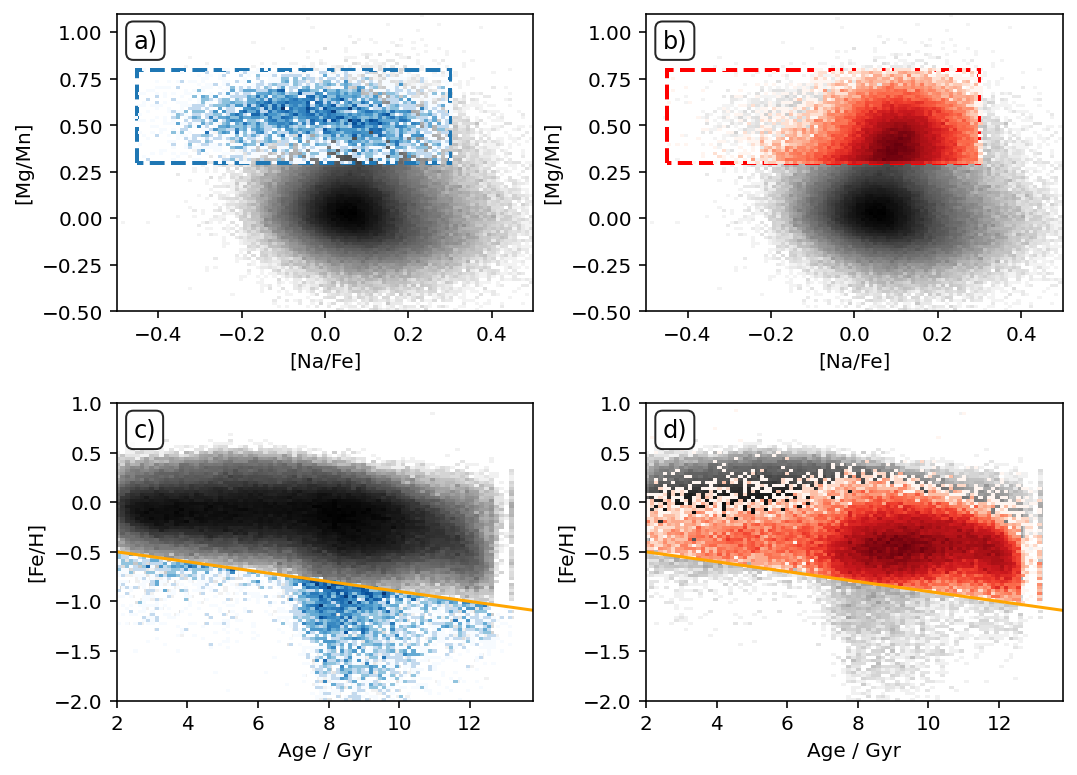

In [212]:
def plot_nafe_mgmn_dissection():

    f, gs = plt.subplots(2,2,figsize=(7.5,5.5))

    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
    
    selection_na_fe = [-0.45,0.3]
    selection_mg_mn = [0.3,0.8]
    
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] < -0.4-0.05*obs['age_bstep'])
    )

    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'C0',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')

    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Blues',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax = gs[1,0]
    ax.text(0.04,0.95,'c)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Blues',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')
    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )


    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
        
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )

    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'r',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax = gs[1,1]
    ax.text(0.04,0.95,'d)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Reds',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )
    
    plt.tight_layout()
    
    plt.savefig('figures/NaFe_MgMn_selection_Age_FeH_dissection.png',bbox_inches='tight',dpi=200)
    
plot_nafe_mgmn_dissection()